# COMP578 Data Mining Spring 2017
## Assignment 6

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis
import sklearn.preprocessing
import sklearn.neighbors
import sklearn.metrics

import statsmodels.api as sm
import statsmodels.formula.api as smf

from itertools import combinations

url_data = "http://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data"

## Columns: BI-RADS Assessment, Age, Shape, Margin, Density, Severity
names = ['BI-RADS', 'Age', 'Shape','Margin','Density','Severity']
data = pd.read_csv(url_data, header=None, names=names, na_values='?')
data = data.interpolate(method='linear', axis=0, inplace=False)

In [5]:
def crossvalidate(data,predictor,target):
    p_order = np.arange(1,11)
    r_state = np.arange(0,10)

    regr = sklearn.linear_model.LinearRegression()
    mses = []
    # Generate random splits of the dataset
    for x in range (0,100):
        # split the dataset into training and testing sets (random_state indicates the split)
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data[predictor], data[target].ravel(),
                                                            test_size=0.1, random_state=x)

        regr.fit(X_train, y_train)
        pred = regr.predict(X_test)
        
        # collect all MSEs in Z; i is the order (on the x axis) and j is the split (a curve in the plot)
        mses.append(sklearn.metrics.mean_squared_error(y_test, pred))
    
    return np.mean(mses)

In [6]:
def ploterrors(avgframe):
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(avgframe['Number of Predictors'],avgframe['Average MSE'])
    plt.xlabel('Number of Predictors')
    plt.ylabel('Average Mean Squared Error')
    plt.xticks([x for x in (1,2,3,4,5)])
    plt.show()

def runtask(data, target):
    errors_frame = pd.DataFrame(columns=['Number of Predictors','Predictors','Average MSE'])
    
    #get list of predictors, excluding the target
    headlist = list(data)
    headlist.remove(target)
    
    #create list of all possible combinations
    combo = []
    for x in (1,2,3,4,5):
        combo.extend(combinations(headlist,x))
    combolist = [list(x) for x in combo] # format the list in a way the fitter likes

    for predictor in combolist:
        rowcount = len(errors_frame)
        if predictor != target:
            avgmse = crossvalidate(data,predictor,target) #average MSE for plotting
            errors_frame.loc[rowcount]= [len(predictor),predictor,avgmse]
            rowcount = rowcount+1
    
    
    avgframe = errors_frame.groupby(['Number of Predictors'],as_index=False)['Average MSE'].mean()
    
    #Sort by best MSE
    errors_frame.sort_values('Average MSE', inplace=True)
    errors_frame.reset_index(inplace=True)
    
    best_predictors = errors_frame['Predictors'][0]

    ploterrors(avgframe)
    print('The best set of predictors for ' + target + ' is: ' + str(best_predictors))

### Task 1
##### 5 points

Use crossvalidation techniques to select best predictors of `severity` in the [Mammographic Mass Data Set](http://archive.ics.uci.edu/ml/datasets/Mammographic+Mass) from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/) following the best subset selection approach.

Compare performances of the models using 10-fold crossvalidation by plotting a graph showing error rates as a function of the number of predictors.

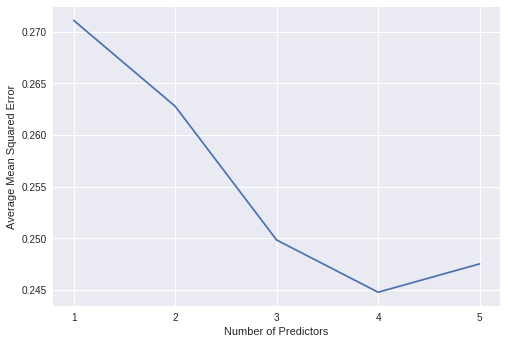

The best set of predictors for Severity is: ['Age', 'Shape', 'Margin']


In [7]:
target = 'Severity'
runtask(data,target)

### Task 2
##### 5 points

Use crossvalidation techniques to select best predictors of `BI_RADS` in the `Mammographic Mass Data Set` following the best subset selection approach.

Compare performances of the models using 10-fold crossvalidation by plotting a graph showing error rates as a function of the number of predictors.

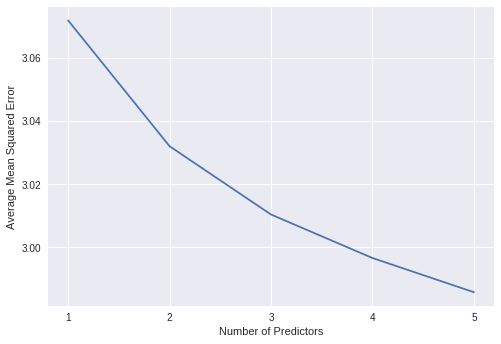

The best set of predictors for BI-RADS is: ['Shape', 'Severity']


In [8]:
target = 'BI-RADS'
runtask(data,target)

### Task 3
##### 5 points

Using the data set `Hitters` (from Lab_06), apply the forward stepwise selection to select best predictors of the players salaries.

Illustrate the performance of the models with increasing number of predictors using a plot showing the error rate as a function of the number of parameters. Show the name of the added predictors at each step (vertically as a label of the tick on the x axis).

(start with null model, then increment upward

In [9]:
hitters = pd.read_csv('Hitters.csv', index_col=0)
dummies = pd.get_dummies(hitters[['League', 'Division', 'NewLeague']])
X_ = hitters.drop(['League', 'Division', 'NewLeague'], axis=1).astype('float64')
hitters_data = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
hitters_data = hitters_data[np.isfinite(hitters_data['Salary'])]

FileNotFoundError: File b'Hitters.csv' does not exist

In [8]:
def plotforwardselect(frame):
    labels = frame['Added Predictor'].tolist()
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(frame.index,frame['Average MSE'])
    plt.xlabel('Added Predictor')
    plt.xticks([x for x in range (0,len(labels))],labels, rotation='vertical')
    plt.ylabel('Average Mean Squared Error')
    plt.title('Error Rates Using Forward Stepwise Selection')
    plt.show()

In [13]:
def forwardselect(data,target):
    errors_frame = pd.DataFrame(columns=['Number of Predictors','Predictors','Average MSE'])
    
    #Generate list of predictors
    headlist = list(data)
    headlist.remove(target)
    
    #Containers for the best predictor in a step, and the collective best predictors in order
    best_predictor = []
    combined_predictors = []
    
    forwardstep_frame = pd.DataFrame(columns=['Added Predictor','Average MSE'])

    for x in range (0,len(headlist)): #combinations of predictors in sets up to, in this case, 5
        errors_frame = pd.DataFrame(columns=['Added Predictor','Average MSE'])
        try:
            headlist.remove(best_predictor)
        except ValueError:
            pass

        for predictor in headlist:
            rowcount = len(errors_frame)
            combined_test = list(combined_predictors)
            if x == 0:
                avgmse = crossvalidate(data,[predictor],target) #average MSE for comparison
            else:
                combined_test.append(predictor)
                avgmse = crossvalidate(data,combined_test,target)
            errors_frame.loc[rowcount]= [[predictor],avgmse]
            
        errors_frame.sort_values('Average MSE', inplace=True)
        errors_frame.reset_index(drop=True,inplace=True)
        
        best_predictor = errors_frame['Added Predictor'][0][0]
        best_mse = errors_frame['Average MSE'][0]
        combined_predictors.append(best_predictor)
        
        forwardstep_frame.loc[x] = [best_predictor,avgmse]
    print(forwardstep_frame,x)
    return forwardstep_frame

In [14]:
target = 'Salary'
forwardframe = forwardselect(hitters_data,target)

   Added Predictor    Average MSE
0             CRBI  210252.063905
1             Runs  138786.859819
2          PutOuts  120428.604125
3       Division_W  116164.353261
4            Walks  111796.678806
5          Assists  111614.289414
6            Years  112217.803646
7           CHmRun  112887.340304
8           Errors  113514.529593
9            AtBat  114069.848567
10            Hits  114687.857910
11          CWalks  112792.787425
12           CRuns  113722.388706
13          CAtBat  113825.661442
14     NewLeague_N  113422.074808
15        League_N  114085.828324
16           HmRun  116823.567098
17             RBI  117856.617584
18           CHits  119375.899500 18


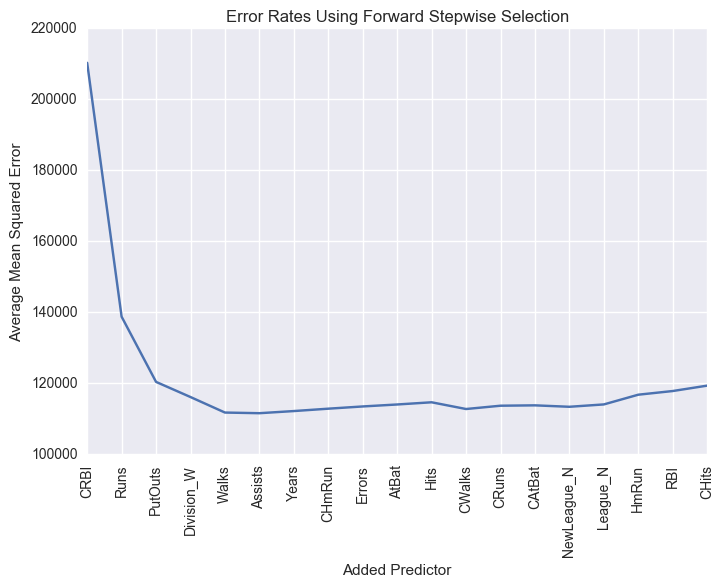

In [15]:
plotforwardselect(forwardframe)

Here we see that MSE trails off significantly within the first five added predictors. Despite some slight fluctuations, MSE generally remains level with each added predictor thereafter.

### Task 4
##### 5 points

Using the data set `Hitters`, apply the backward stepwise selection to select best predictors of the players salaries.

Illustrate the performance of the models with decreasing number of predictors using a plot showing the error rate as a function of the number of parameters. Show the name of the added predictors at each step (vertically as a label of the tick on the x axis). It should be shown in reverse order; i.e., starting with 20 and ending with 1.

In [16]:
def backwardstep(data,target):
    errors_frame = pd.DataFrame(columns=['Number of Predictors','Predictors','Average MSE'])
    
    #Generate list of predictors
    headlist = list(data)
    headlist.remove(target)
    
    #Containers for the best predictor in a step, and the collective best predictors in order
    best_predictor = []
    combined_predictors = list(headlist)
    
    backwardstep_frame = pd.DataFrame(columns=['Removed Predictor','Average MSE'])

    for x in range (0,len(headlist)):
        errors_frame = pd.DataFrame(columns=['Removed Predictor','Average MSE'])

        for predictor in combined_predictors:
            combined_test = list(combined_predictors)
            
            avgmse = crossvalidate(data,combined_test,target)
            errors_frame.loc[len(errors_frame)]= [[predictor],avgmse]
            combined_test.remove(predictor)

            
        errors_frame.sort_values('Average MSE', inplace=True)
        errors_frame.reset_index(drop=True,inplace=True)
        
        best_predictor = errors_frame['Removed Predictor'][0][0]
        best_mse = errors_frame['Average MSE'][0]
        combined_predictors.remove(best_predictor)
        
        backwardstep_frame.loc[x] = [best_predictor,avgmse]
    print(backwardstep_frame)
    return backwardstep_frame

In [17]:
def plotbackwardselect(frame):
    labels = frame['Removed Predictor'].tolist()
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(frame.index,frame['Average MSE'])
    plt.xlabel('Removed Predictor')
    plt.xticks([x for x in range (0,len(labels))],labels, rotation='vertical')
    plt.ylabel('Average Mean Squared Error')
    plt.title('Error Rates Using Backward Stepwise Selection')
    plt.show()

In [18]:
target = 'Salary'
backwardframe = backwardstep(hitters_data,'Salary')

   Removed Predictor    Average MSE
0              AtBat  119375.899500
1               Hits  122197.187952
2              HmRun  121713.812503
3               Runs  120217.073043
4                RBI  118764.415363
5              Walks  117197.380239
6              Years  126451.325244
7             CAtBat  125738.070244
8              CHits  126832.886940
9             CHmRun  129384.057680
10             CRuns  127545.954126
11              CRBI  125015.797174
12            CWalks  136453.313267
13           PutOuts  187401.462876
14           Assists  205757.119502
15            Errors  204445.586455
16          League_N  203147.390793
17        Division_W  202564.773659
18       NewLeague_N  210252.063905


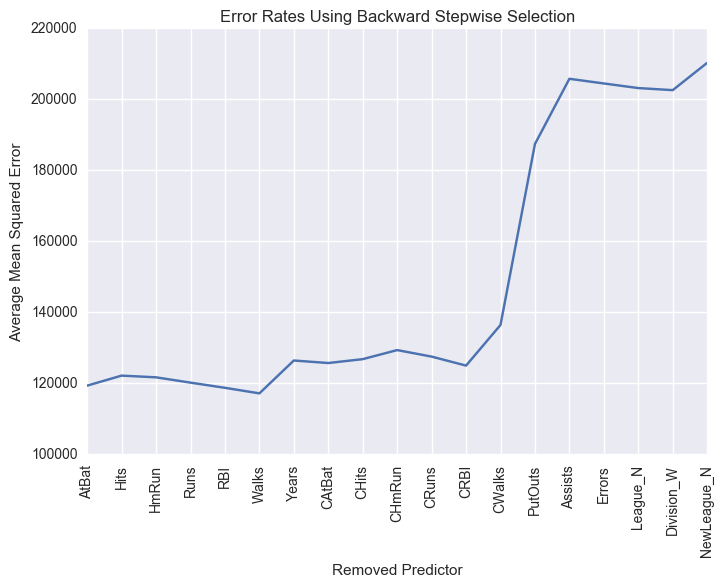

In [19]:
plotbackwardselect(backwardframe)

Average MSE remains fairly level, however it increases a bit earlier than might be expected given the graph for forward stepwise selection, and with different predictors. This is because of the different starting point (all predictors), and the subtractive nature of this method. 

### Task 5
##### 10 points

Compare the performance of models built without regularization, with Ridge ($L_2$) regularization, and with Lasso ($L_2$) regularization to predict `BI_RADS` in the `Mammographic Mass Data Set`.

Use all predictors.

Find best regularization parameters using crossvalidation for Ridge() and for Lasso() before making the comparisons.

Use crossvalidation to evaluate performance of the models using boxlots that show error rates for 100 trials, where each trial is a 10-fold crossvalidation. There should be three boxplots in the plot; one for each of the models.

In [20]:
def task56plots(regr_list,lasso_list,ridge_list,predictor):
    data = [regr_list,lasso_list,ridge_list]
    # fig, (ax1,ax2,ax3) = plt.subplots(1,3)
    plt.figure()
    plt.boxplot(data)
    plt.title(predictor)
    plt.xticks([1,2,3],['Non-Regularized','Lasso','Ridge'])
    plt.ylim(0,1)
    plt.ylabel('Mean Squared Error')
    plt.tight_layout()
    plt.show()

def task56errors(data,target,fitter):
    
    regr = sklearn.linear_model.LinearRegression()
    lasso = sklearn.linear_model.Lasso(max_iter=10000)
    ridge = sklearn.linear_model.Ridge()
    lambdas = 0.5*(4**np.linspace(10,-2,100))
    
    for predictor in list(data):
        if predictor != target:
            regr_errors = []
            lasso_errors = []
            ridge_errors = []
            for x in range (0,100):
                X_train, X_test, y_train, y_test = sklearn.model_selct.train_test_split(data[[predictor]], data[target],
                                                                test_size=0.1, random_state = x)
                ##linear regression fit
                fitter.fit(X_train,y_train)
                pred = fitter.predict(X_test).ravel()
                regr_errors.append(sklearn.metrics.mean_squared_error(y_test,pred))
                
                ##lasso fit
                lassocv = sklearn.linear_model.LassoCV(n_alphas=lambdas.size, alphas=lambdas, cv=10, max_iter=10000)
                lassocv.fit(sklearn.preprocessing.scale(X_train), y_train.as_matrix().ravel())
                
                lasso.set_params(alpha=lassocv.alpha_)
                lasso.fit(sklearn.preprocessing.scale(X_train), y_train)
                val_lassoerr = sklearn.metrics.mean_squared_error(y_test, lasso.predict(sklearn.preprocessing.scale(X_test)))
                lasso_errors.append(val_lassoerr)
                
                ##ridge fit
                ridgecv = sklearn.linear_model.RidgeCV(alphas=lambdas, scoring='mean_squared_error')
                ridgecv.fit(sklearn.preprocessing.scale(X_train), y_train)
                ridge.set_params(alpha=ridgecv.alpha_)
                ridge.fit(sklearn.preprocessing.scale(X_train), y_train)
                val_ridgeerr = sklearn.metrics.mean_squared_error(y_test, ridge.predict(sklearn.preprocessing.scale(X_test)))
                ridge_errors.append(val_ridgeerr)
            task56plots(regr_errors,lasso_errors,ridge_errors,predictor)
            print('Non-Regularized: ' + str(regr_errors[:5]))
            print('Lasso: ' + str(lasso_errors[:5]))
            print('Ridge: ' + str(ridge_errors[:5]))
            print('=========================================================')


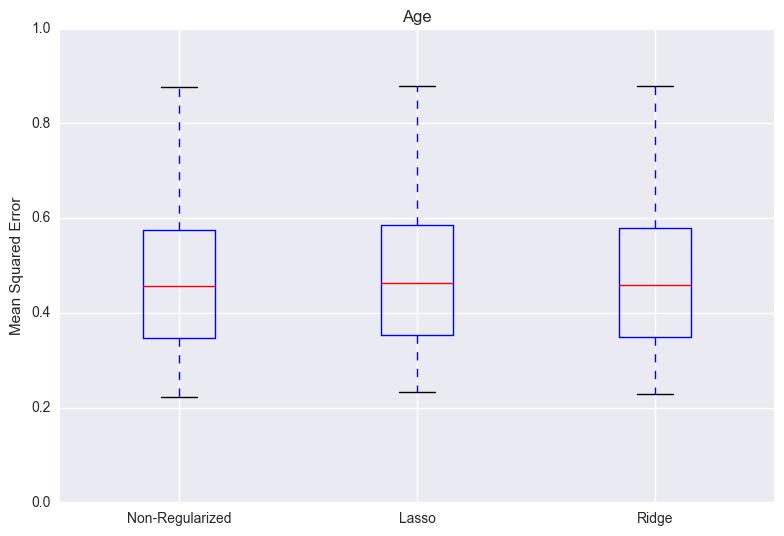

Non-Regularized: [0.57204046633380379, 0.37069537906385974, 0.39624986633901416, 0.38074323791568176, 27.171473973154807]
Lasso: [0.57304775316579282, 0.37421840107520365, 0.3973665568809186, 0.38663240148060379, 27.148676458760303]
Ridge: [0.57587917570497604, 0.37253022459825202, 0.39383395486634537, 0.38293226930254165, 27.169788095464206]


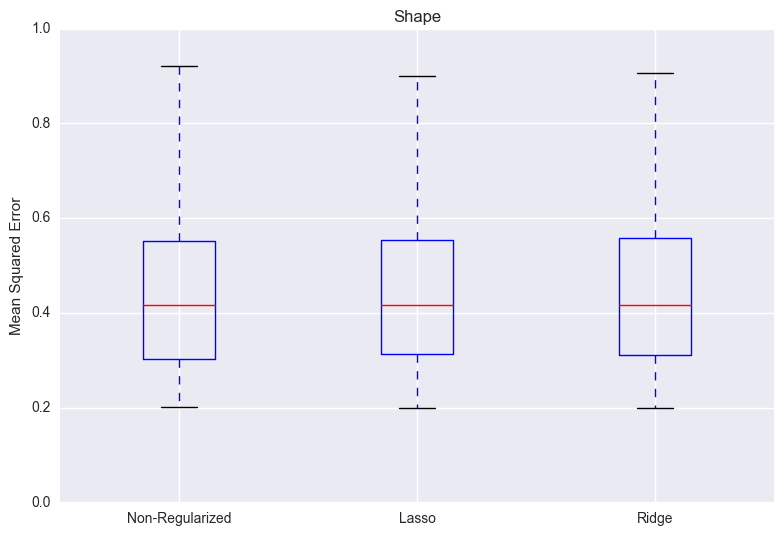

Non-Regularized: [0.53554409349803278, 0.35738180904867345, 0.29305615661377737, 0.35623703699043646, 26.716285112477156]
Lasso: [0.53012573754936887, 0.37677425274610388, 0.31069436917157633, 0.35384222764283035, 26.739645525039691]
Ridge: [0.53293423420562858, 0.38115944573055227, 0.30770142988391663, 0.35473449394917689, 26.70789504511848]


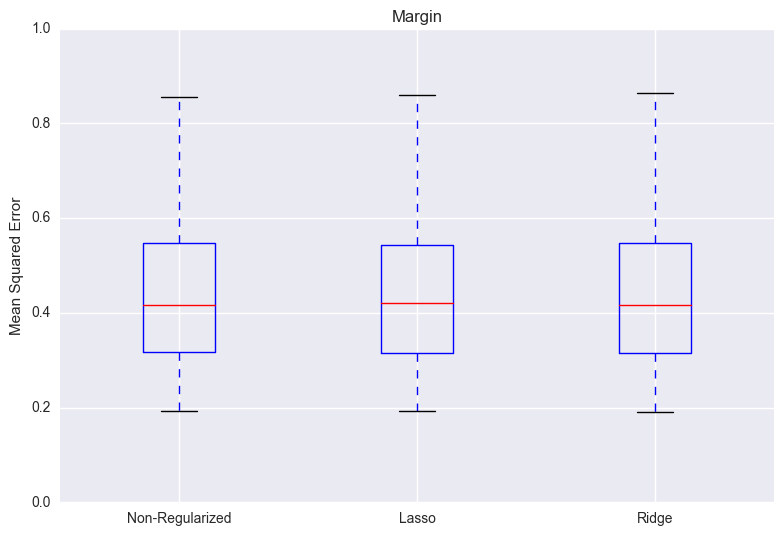

Non-Regularized: [0.53695469350373637, 0.36125442620048986, 0.3245523462189609, 0.33441234582005785, 26.971257112271143]
Lasso: [0.542276727619315, 0.38223831139373277, 0.34160676650547983, 0.33406981876467196, 26.95573872441598]
Ridge: [0.54695251102296416, 0.38824565060094818, 0.33811551545506663, 0.33103245091493871, 26.952020516416532]


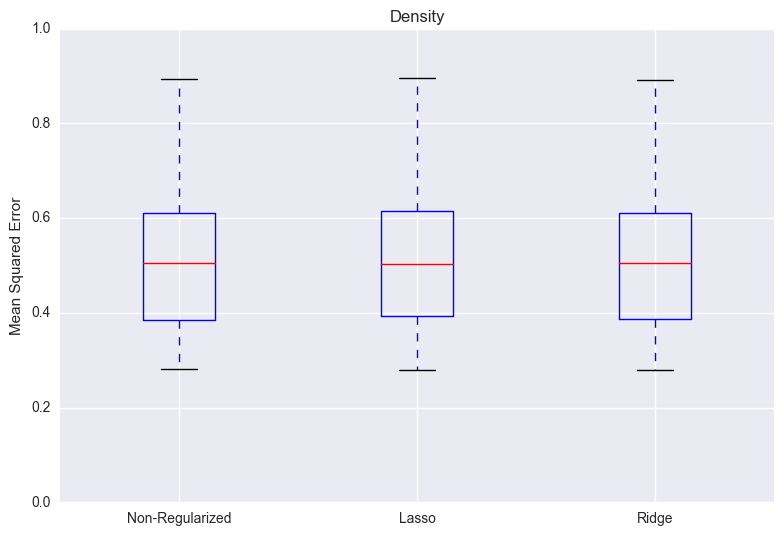

Non-Regularized: [0.57368344298303298, 0.4034124175853025, 0.43459850353174101, 0.42844157956286671, 27.042594871359661]
Lasso: [0.57791901012389002, 0.40339000869119812, 0.43967958508336497, 0.42840489735695914, 27.053504696195141]
Ridge: [0.57417893412331988, 0.4029854159250742, 0.43377895297548075, 0.42815850160910146, 27.049814072032319]


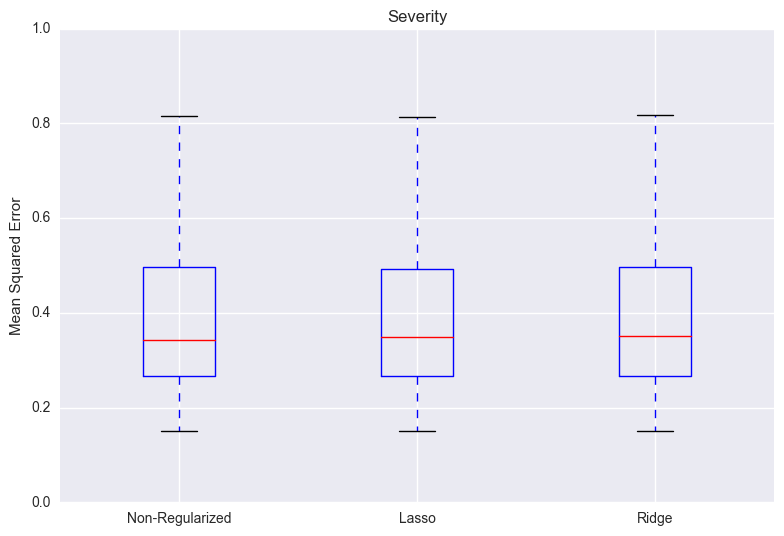

Non-Regularized: [0.51740726353663935, 0.27511911958565399, 0.27455934674322968, 0.24027807032629744, 26.593623076532481]
Lasso: [0.50586536849148378, 0.30277695060487947, 0.28282739044899646, 0.24107426253781078, 26.540473890619719]
Ridge: [0.51070561912677293, 0.30571903111288246, 0.28266416120268012, 0.23892263164647773, 26.504857015204905]


In [21]:
target = 'BI-RADS'
fitter = sklearn.linear_model.LinearRegression()
task56errors(data,target,fitter)

When predicting BI-RADS, all three techinques perform fairly similarly (though not identically, as shown in the first five rows of the collected errors for each). Visually, I would say that Severity serves as the most reliable predictor.

### Task 6
##### 10 points

Utilizing the regularization parameters of [sklearn LogisticRegression()](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) and using crossvalidatian techniques compare performance of models with no regularization, with $L_1$ regularization, and $L_2$ regularization to predict `severity` in the `Mammographic Mass Data Set`.

Use all predictors.

Use `liblinear` solver (since the othersolvers available in sklearn logistic regression do not support full regularization mechansim as of now - 3/1/2017).

To illustrate the performance of the models, plot two graphs that show average error rate obtained through crossvalidation as a function of the parameter `C` in `LogisticRegression()`. `C` controls the level of regularization, and is simply an inverse of $\lambda$ that we used in the lecture and the lab (i.e., $C=\frac{1}{\lambda}$; it must hold that $C>0$). If C is set to a very large value it will shutdown the regularization in practical terms (same as $\lambda\rightarrow0$).
>There is no option as of now (3/1/2017) to turn off regularization.

(check the penalty parameter, C parameter - regularization c is related to lambda (inverse) )

No regularization = very large C or very small lambda

In [25]:
def plotCvsErrors(frame,predictor):
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(frame.iloc[:,0],frame.iloc[:,1])
    plt.xlabel(frame.columns.values[0])
    plt.ylabel(frame.columns.values[1])
    plt.title(frame.columns.values[0] + ' vs ' + frame.columns.values[1] + ': ' + str(predictor))
    plt.ylim(0,1)
    plt.show()   

def task6modelperformance(data,target):
    for predictor in list(data):
        if predictor != target:
            precision_frame = pd.DataFrame(columns=['C Value','Average Precision'])
            recall_frame = pd.DataFrame(columns=['C Value','Average Recall'])
            mattcorr_frame = pd.DataFrame(columns=['C Value','Average MCC'])
            
            for x in range (1,25,1): #value of C (inverse lambda)
                C_value = 1/(2**x)
                for y in range (0,10): 
                    
                    precision_catcher = []
                    recall_catcher = []
                    mattcorr_catcher = []
                    
                    X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(data[[predictor]], data[target],
                                                                    test_size=0.1,random_state=y)

                    logreg = sklearn.linear_model.LogisticRegression(solver='liblinear',C=C_value)#for each loop, set C to increasing values
                    
                    logreg.fit(X_train,y_train)
                    pred = logreg.predict(X_test)
                    
                    precision = sklearn.metrics.precision_score(y_test,pred)
                    precision_catcher.append(precision)
                    
                    recall = sklearn.metrics.recall_score(y_test,pred)
                    recall_catcher.append(recall)
                    
                    mattcorr = sklearn.metrics.matthews_corrcoef(y_test,pred)
                    mattcorr_catcher.append(mattcorr)
                    
                average_precision = np.mean(precision_catcher)
                precision_frame.loc[len(precision_frame)] = [C_value,average_precision]
                
                average_recall = np.mean(recall_catcher)
                recall_frame.loc[len(recall_frame)] = [C_value,average_recall]
        
                average_mattcorr = np.mean(mattcorr_catcher)
                mattcorr_frame.loc[len(mattcorr_frame)] = [C_value,average_mattcorr]
     
        plotCvsErrors(precision_frame,predictor)
        plotCvsErrors(recall_frame,predictor)
        plotCvsErrors(mattcorr_frame,predictor)
        print('=================================================')

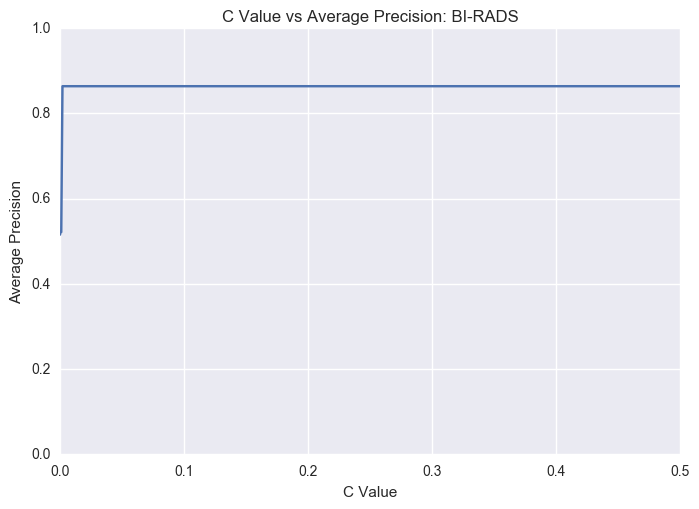

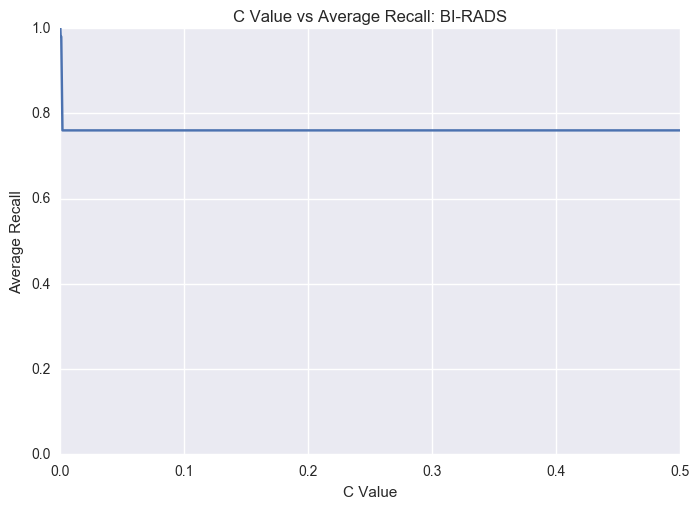

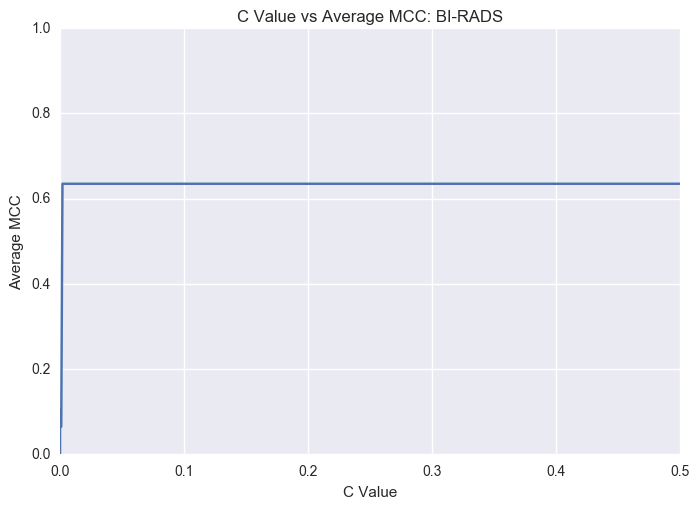

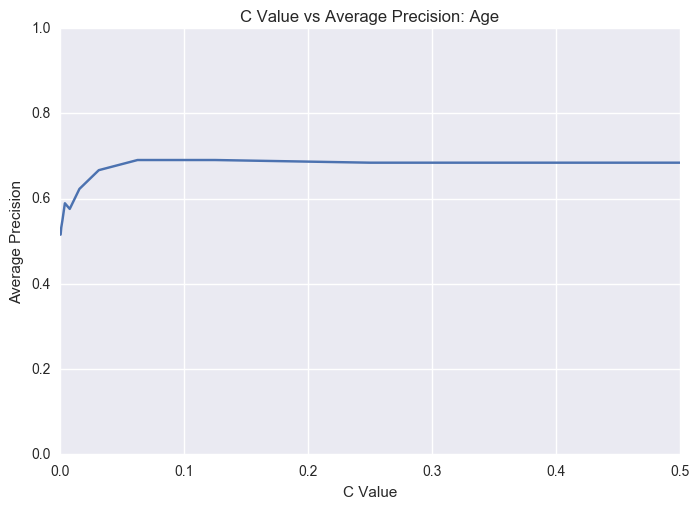

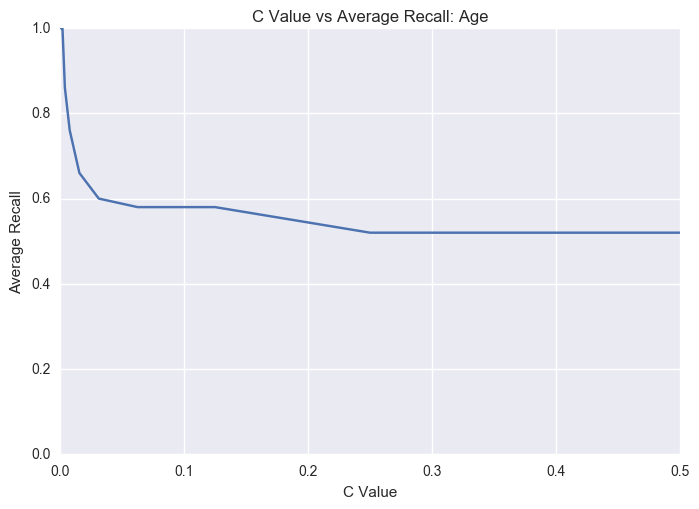

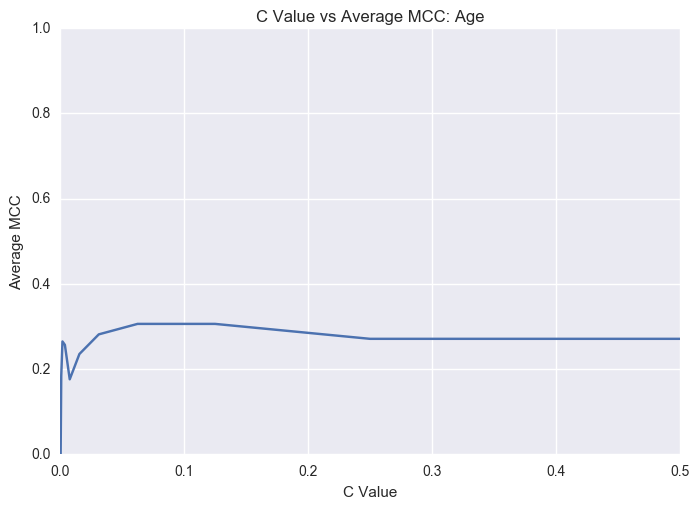

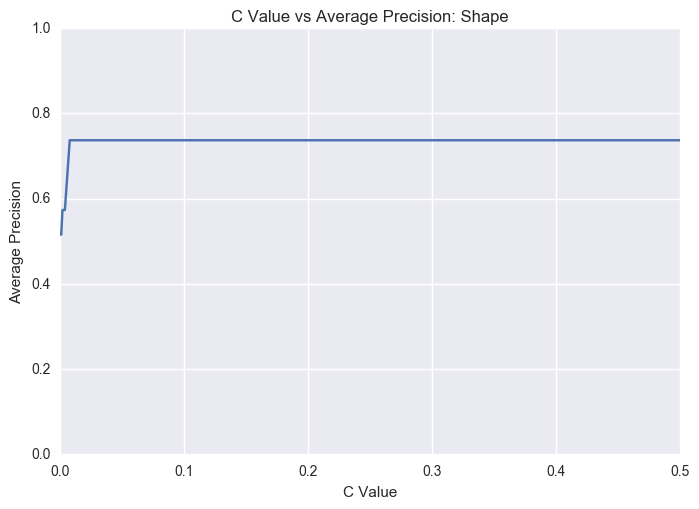

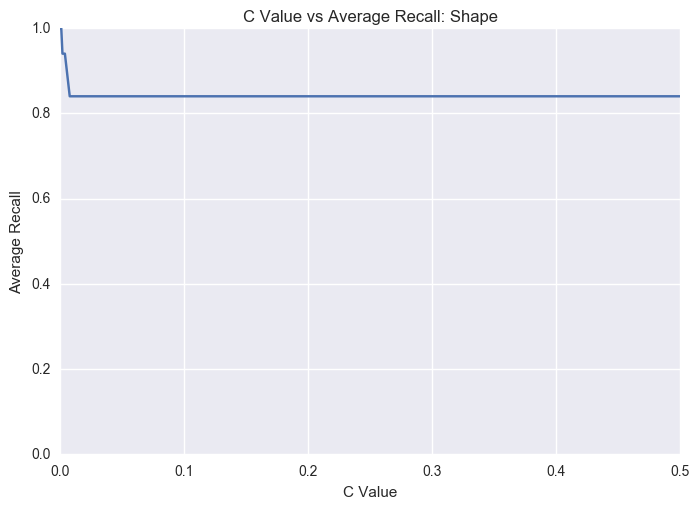

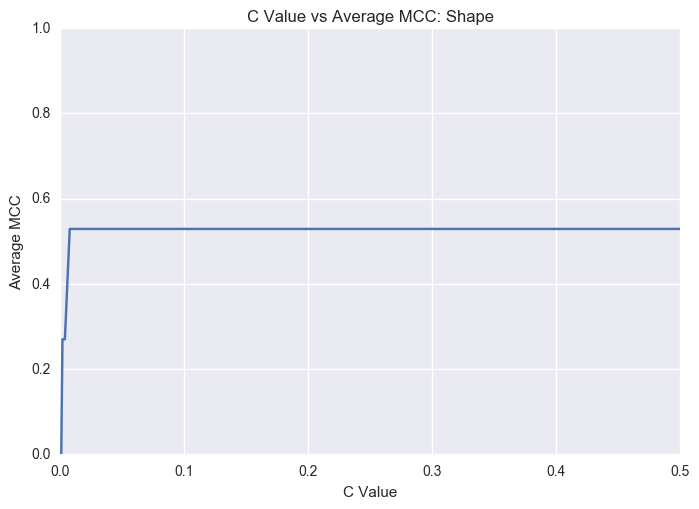

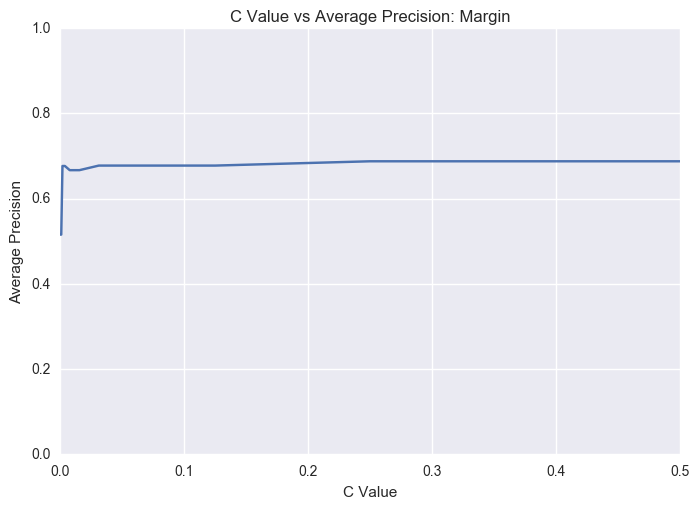

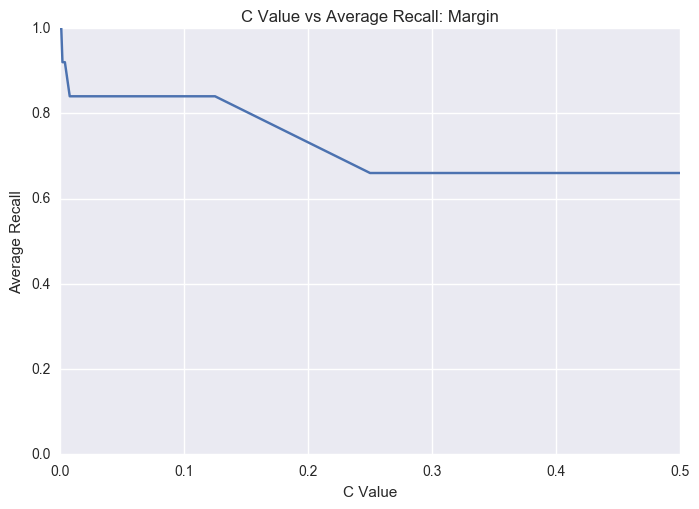

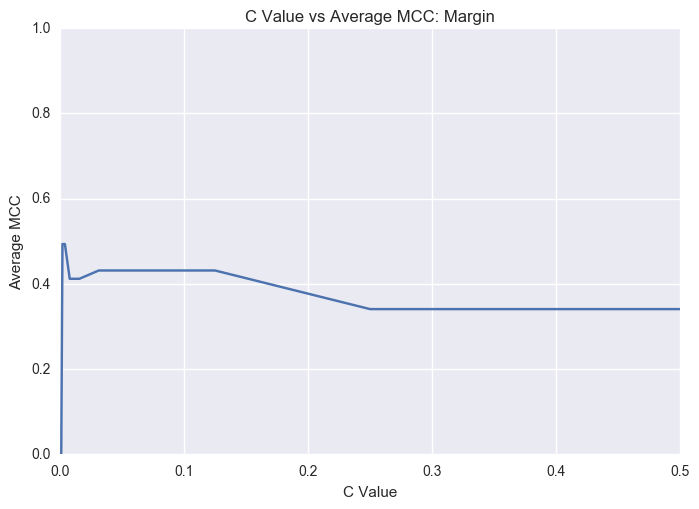

/home/omar/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


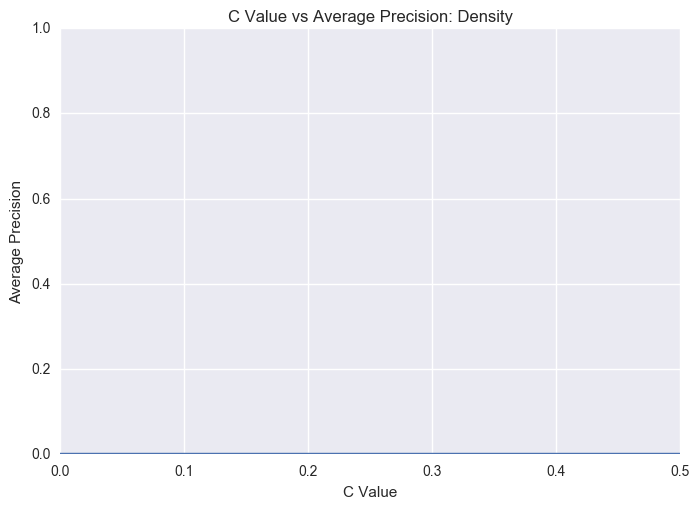

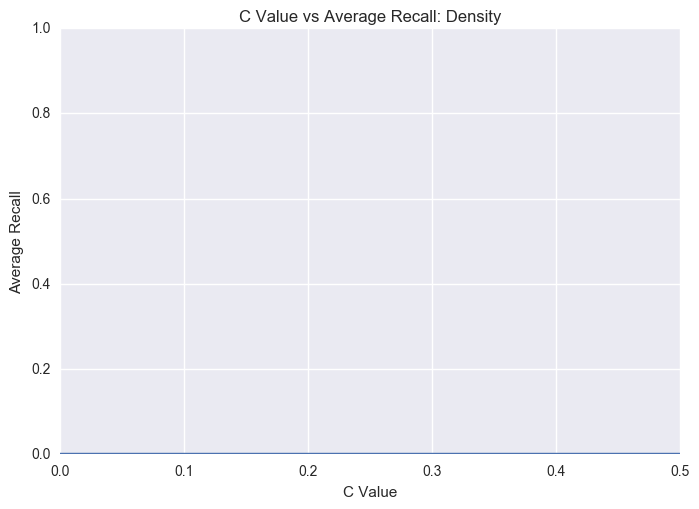

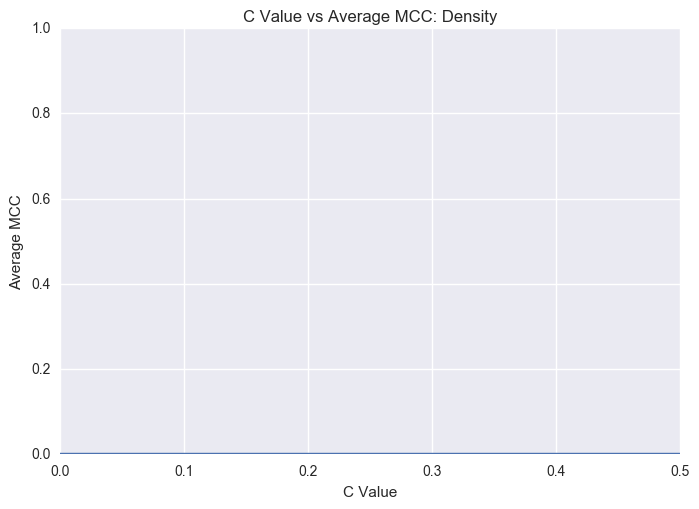

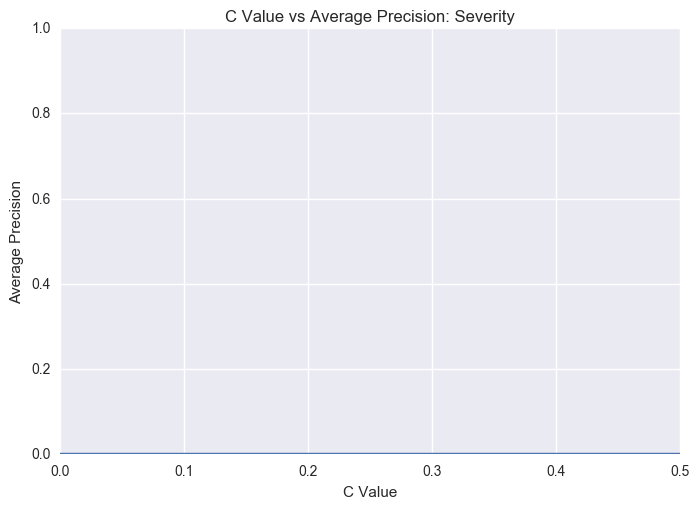

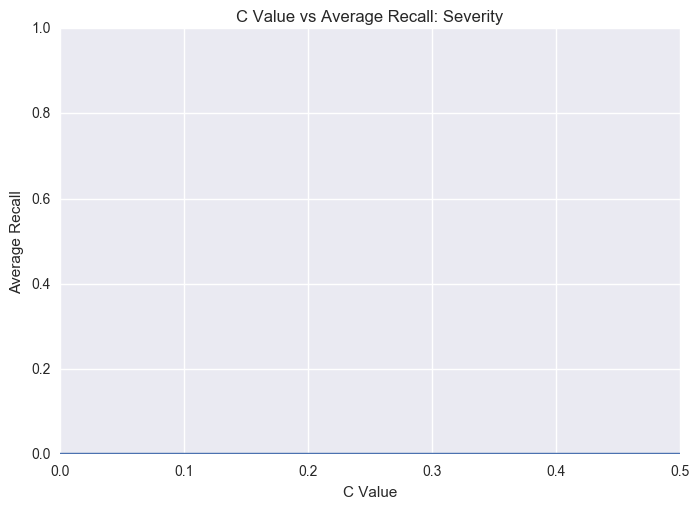

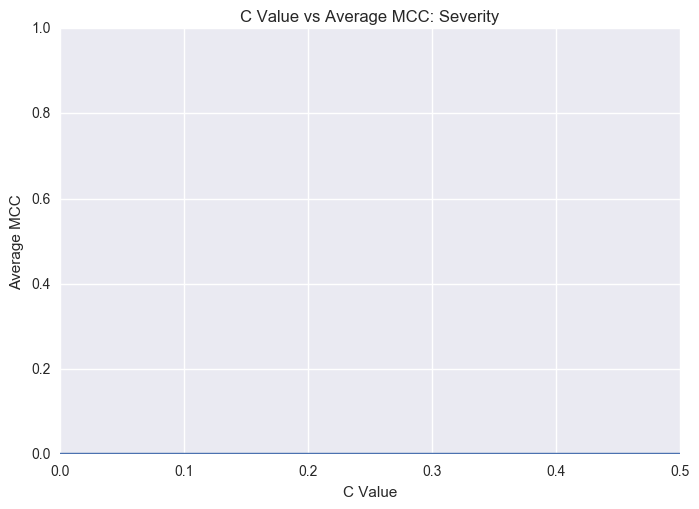

In [26]:
task6modelperformance(data,'Severity')

Mattews correlation coefficient is used to describe the quality of a confusion matrix in a single number. Recall descibes how well the model performs in terms of returning the available correct values, and precison describes how accurate the recall was. BI-RADS performed the best overall in terms of all three values collectively, followed by Shape and Age. Density and Severity did not return predictions.

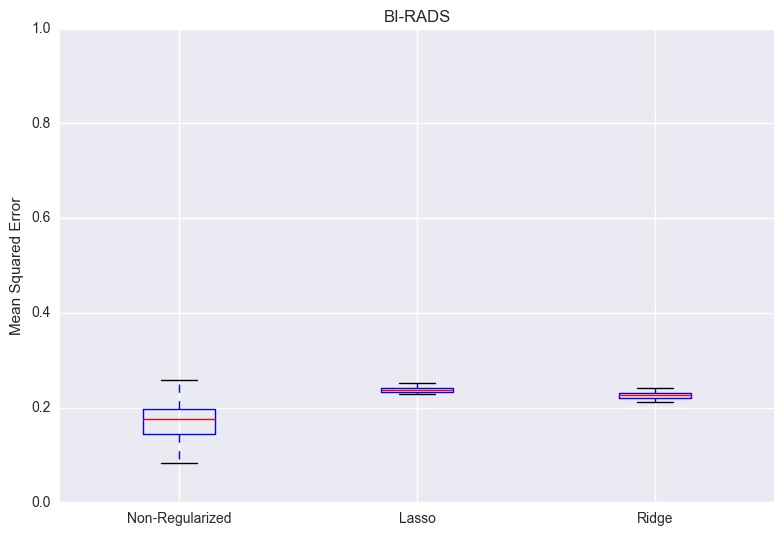

Non-Regularized: [0.20618556701030927, 0.18556701030927836, 0.14432989690721648, 0.13402061855670103, 0.18556701030927836]
Lasso: [0.23914127661114223, 0.2305989711221659, 0.23165661346226374, 0.23678682592893691, 0.25615907034858071]
Ridge: [0.23203085991228475, 0.21979916199797264, 0.21842638054270441, 0.22143549842734975, 0.26341438795698369]


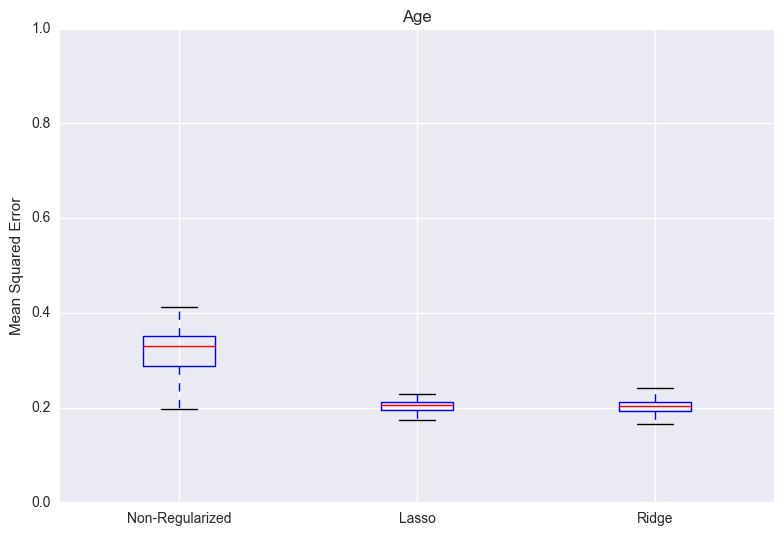

Non-Regularized: [0.34020618556701032, 0.37113402061855671, 0.26804123711340205, 0.36082474226804123, 0.38144329896907214]
Lasso: [0.20986341132573266, 0.24266516948595149, 0.18484511254513328, 0.20891829216926638, 0.20687652792936831]
Ridge: [0.20984118546120384, 0.24941169492822138, 0.18066584138191769, 0.20825224845273577, 0.20734613210608979]


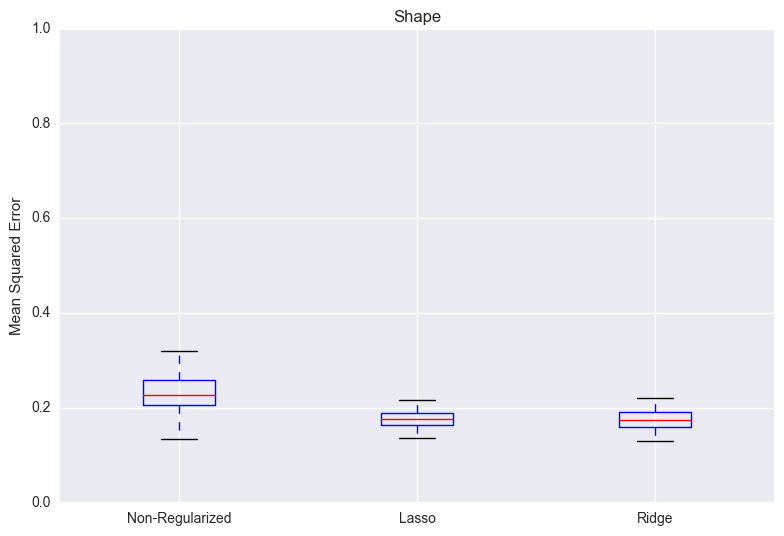

Non-Regularized: [0.18556701030927836, 0.19587628865979381, 0.13402061855670103, 0.22680412371134021, 0.26804123711340205]
Lasso: [0.15688992484086162, 0.15929328031667889, 0.13548480179398562, 0.17978265866761317, 0.18497655227342705]
Ridge: [0.1532272020748815, 0.15672246658578792, 0.12910531917363235, 0.17903032639092945, 0.18608508772031504]


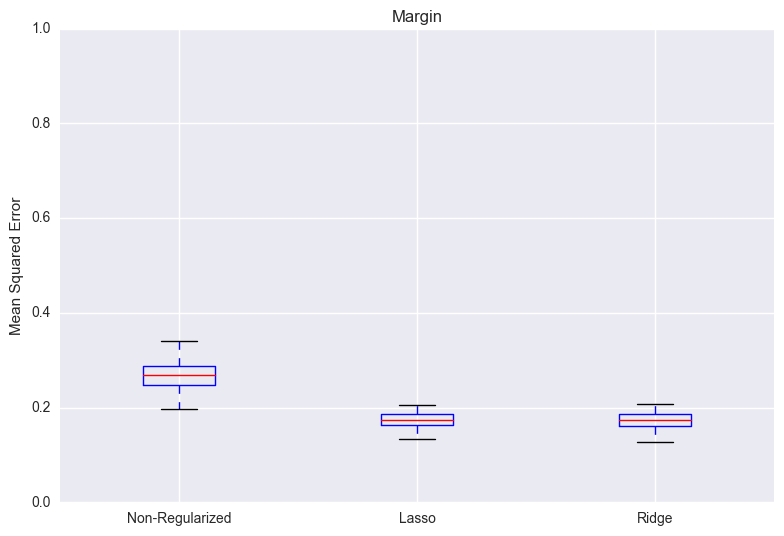

Non-Regularized: [0.26804123711340205, 0.28865979381443296, 0.21649484536082475, 0.22680412371134021, 0.28865979381443296]
Lasso: [0.16672695294198142, 0.1850358963613517, 0.15130602889287809, 0.16639642602350369, 0.18307825731469479]
Ridge: [0.16481499013415118, 0.18634603362297705, 0.14762647660041281, 0.16399992010154557, 0.18417518778924813]


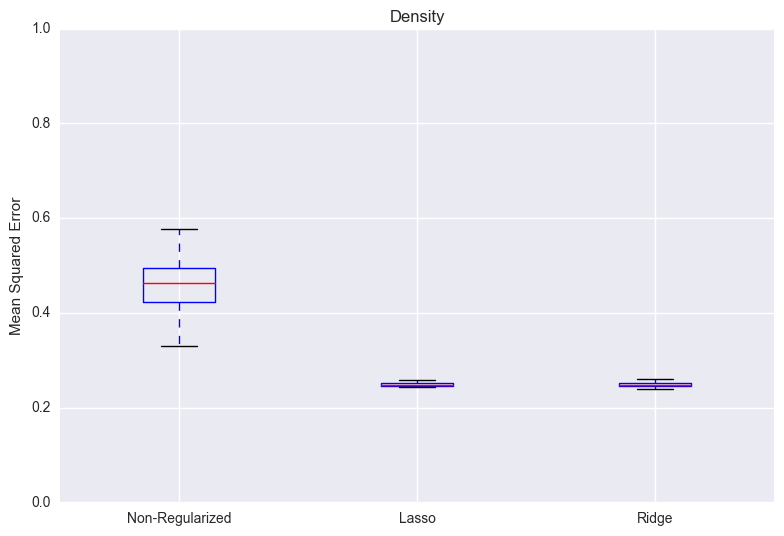

Non-Regularized: [0.47422680412371132, 0.36082474226804123, 0.41237113402061853, 0.50515463917525771, 0.39175257731958762]
Lasso: [0.2494900297903144, 0.24374922776158198, 0.2460387853011469, 0.25216566437571597, 0.24331752892133299]
Ridge: [0.24684875989521027, 0.24501639834172612, 0.24954099038257943, 0.24779450130815509, 0.24272338197710544]


In [24]:
target = 'Severity'
fitter = sklearn.linear_model.LogisticRegression(solver='liblinear')
task56errors(data,target,fitter)

Here the effects of Lasso and Ridge fitting on MSE are much more pronounced than they were with BI-RADS. With the exception of BI-RADS, for each predictor MSE is reduced in comparision to non-regularized fitting which demonstrates the error reduction with these techniques. Shape and Age serve as the best individual predictors for Severity.